CRNN : CNN + RNN
  - CNN : 이미지에서 특징을 추출하고 추출된 특징을 RNN에 넣어서 글자를 예측
  - CTC손실 : 결과가 다양한 방법으로 표현이 가능할때 사용하는 손실, 가능한 모든경로의 확률의 합을 확률로 표현


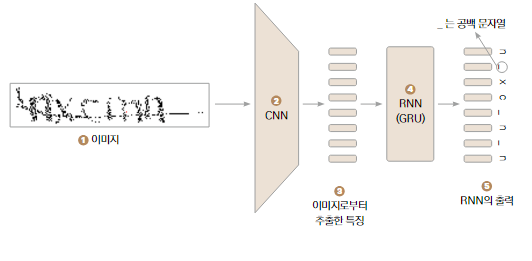

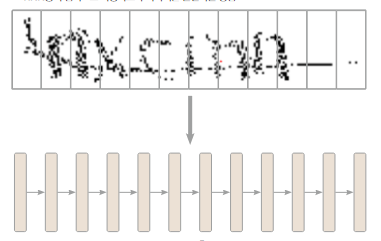

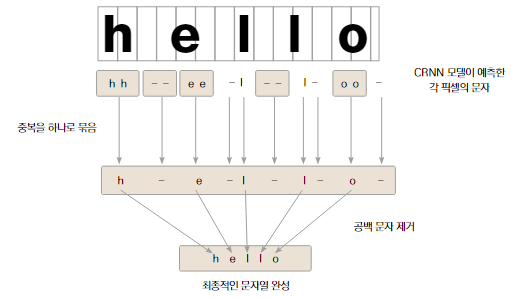

In [1]:
# ctc 손실

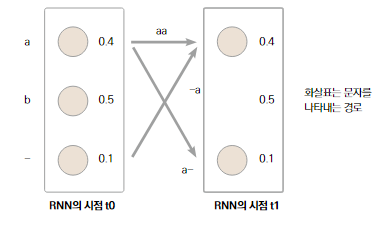

In [2]:
# aa 확률 : 0.4*0.4 \ 0.16
# a- 확률: 0.4*0.1 \ 0.04
# -a 확률: 0.1*0.4 \ 0.04
# 다 더하면.. 0.24의 확률 24%로 a를 타나내고 있음

In [3]:
# CTC 손실이 최소화  되도록 학습

In [ ]:
# 데이터  https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [ ]:
!unzip '/content/drive/MyDrive/캡차/archive.zip'

In [5]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image

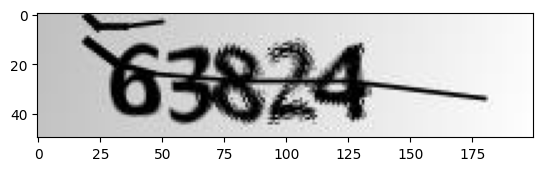

In [6]:
imgfiles = glob.glob("/content/samples/*.png")
imgfile =  Image.open(imgfiles[0])
plt.imshow(imgfile)
plt.show()

In [ ]:
# nng